# LEC Data Challenge

In [1]:
import numpy as np
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, reciprocal
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_confusion_matrix

Using TensorFlow backend.


## Read-in raw data

In [22]:
X = pd.read_csv('training_dataset.csv', sep=';')
Y = pd.read_csv('training_solution.csv', sep=';', header=None)
Xtest = pd.read_csv('test_dataset.csv', sep=';')

## Explore the feature space

In [23]:
def displots(data, nrows, ncolumns):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncolumns, figsize=(15,12))
    features = data.columns
    feature_count = 0
    for i in range(nrows):
        for j in range(ncolumns):
            sns.distplot(data[features[feature_count]], ax=axes[i,j])
            feature_count += 1

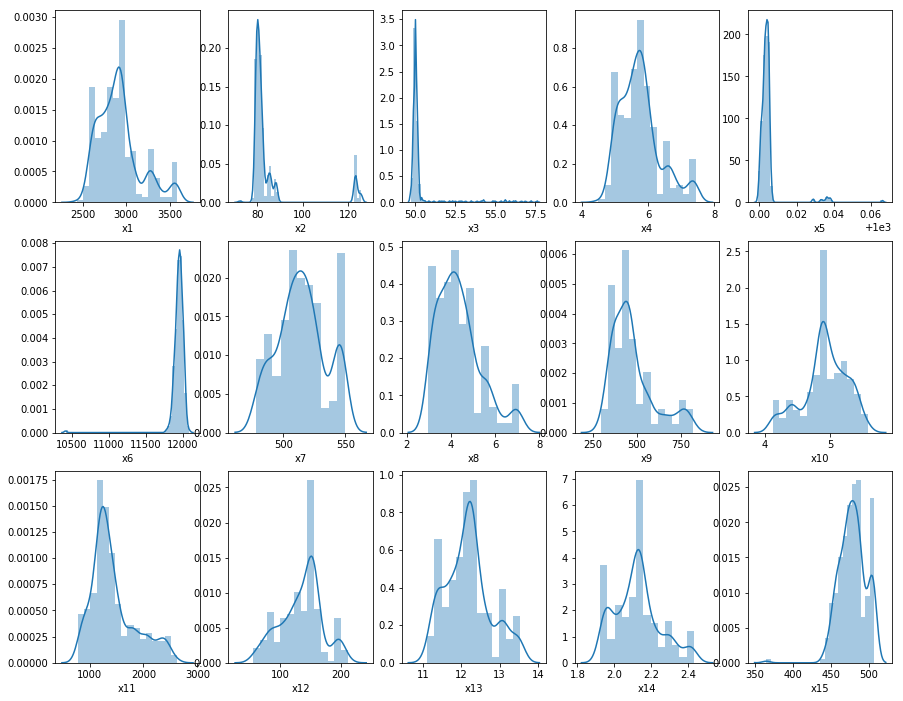

In [24]:
displots(X, 3, 5)

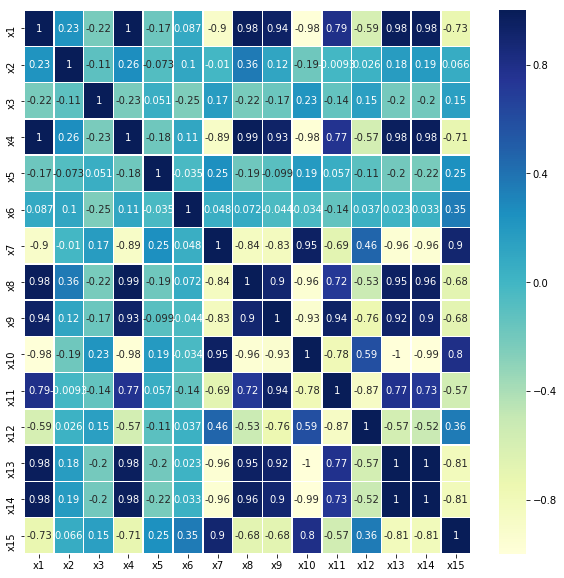

In [25]:
# check correlation across features
corr_matrix = X.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap (corr_matrix,annot=True,linewidths=.5, ax=ax, cmap= "YlGnBu")

## Pre-process data

In [26]:
def get_normalized_data():
    # read-in data
    X = pd.read_csv('training_dataset.csv', sep=';')
    Y = pd.read_csv('training_solution.csv', sep=';', header=None)
    Xtest = pd.read_csv('test_dataset.csv', sep=';')
    
    # convert data to required type
    X = X.values.astype(np.float32)
    Y = Y.values.astype(int)
    Xtest = Xtest.values.astype(np.float32)
    
    # convert to log scale
    X = np.log1p(X)
    Xtest = np.log1p(Xtest)

    # standardize the data
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    np.place(std, std== 0, 1)
    X = (X - mu) / std
    Xtest = (Xtest - mu) / std
    
    
    return X, Y, Xtest

## Check distribution of standardized features

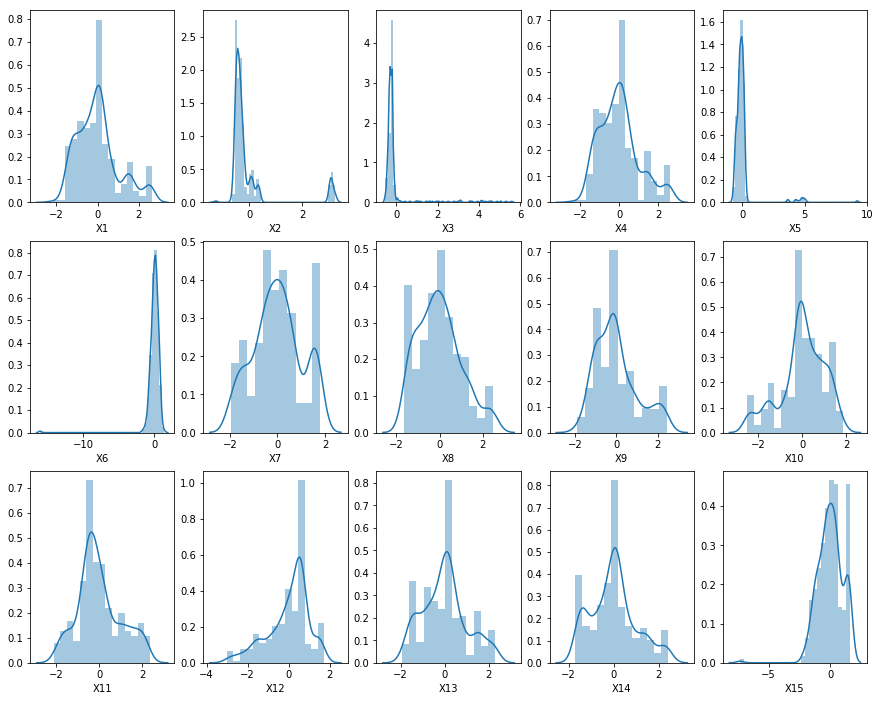

In [27]:
X, Y, Xtest = get_normalized_data()
X = pd.DataFrame(X)
X.columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
                 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15']
displots(X, 3, 5)

In [28]:
# convert features df to a numpy array
X = X.values

# convert feature matrix into a 5085 x 1 "matrix"
X = X.flatten().reshape(-1, 1)

# reshape target matrix into a 5085 x 1 "matrix"
Y = Y.flatten().reshape(-1, 1)

In [29]:
X.shape

(5085, 1)

## Check target class distribution

In [9]:
data = np.concatenate((X,Y), axis = 1)

df = pd.DataFrame(data)
df.columns = ['feature', 'target']
df['target'].value_counts()

0.0    5025
1.0      60
Name: target, dtype: int64

## Split training data into train and dev sets

In [30]:
Xtrain, Xdev, Ytrain, Ydev = train_test_split(X, Y, test_size=0.2, random_state=42)

In [32]:
Xdev.shape

(1017, 1)

### Check distribution of labels in train set before SMOTE

In [11]:
unique, counts = np.unique(Ytrain, return_counts=True)
dict(zip(unique, counts))

{0: 4015, 1: 53}

In [12]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xtrain_res, Ytrain_res = sm.fit_sample(Xtrain, Ytrain)

### Check distribution of labels in train set after SMOTE

In [13]:
unique, counts = np.unique(Ytrain_res, return_counts=True)
dict(zip(unique, counts))

{0: 4015, 1: 4015}

## Logistic Regression

In [14]:
logistic_clf = LogisticRegression()
param_grid = {'C': [1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

# Use grid search to find best hyperparams.
grid_cv = GridSearchCV(logistic_clf, param_grid, scoring='f1', cv=5)

grid_cv.fit(Xtrain_res, Ytrain_res)

print('Best Penalty:', grid_cv.best_estimator_.get_params()['penalty'])
print('Best C:', grid_cv.best_estimator_.get_params()['C'])
print ("Best accuracy: ", grid_cv.best_score_)

Best Penalty: l2
Best C: 1
Best accuracy:  0.880562558004558


### Fit and evaluate new model using optimal hyperparameters

In [17]:
logistic_best_model = LogisticRegression(C=1, penalty="l2")

# Fit and evaluate on dev data
logistic_best_model.fit(Xdev, Ydev)
print("Accuracy: ", logistic_best_model.score(Xdev, Ydev))

# Get prediction on dev data
Ypred = logistic_best_model.predict(Xdev)

# Get dev set metrics
f1_w = f1_score(Ydev, Ypred, average='weighted')
f1_mac = f1_score(Ydev, Ypred, average='macro')
print('The weighted F1 score is:', f1_w*100)
print('The macro F1 score is:', f1_mac*100)

print(classification_report(Ydev, Ypred))

# Get AUC score
print('AUC score on dev set: ', roc_auc_score(Ydev, Ypred))

Accuracy:  0.9950835791543756
The weighted F1 score is: 99.37239763526227
The macro F1 score is: 72.09876543209876
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       1.00      0.29      0.44         7

   micro avg       1.00      1.00      1.00      1017
   macro avg       1.00      0.64      0.72      1017
weighted avg       1.00      1.00      0.99      1017

AUC score on dev set:  0.6428571428571428
0.2857142857142857


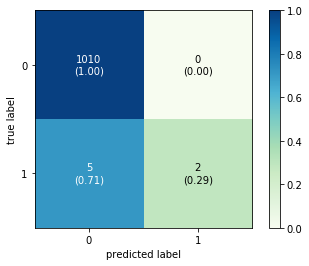

<Figure size 432x288 with 0 Axes>

In [28]:
cm_lr = confusion_matrix(Ydev, Ypred)
fig, ax = plot_confusion_matrix(conf_mat=cm_lr, colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

##  SVM Model

In [14]:
svm_clf = SVC(kernel='rbf')
param_grid = {'C': [1, 10, 100, 1000]},

# Use grid search to find best kernel
grid_cv = GridSearchCV(svm_clf, param_grid, scoring='f1', cv=5)

grid_cv.fit(Xtrain_res, Ytrain_res)

print('Best C:', grid_cv.best_estimator_.get_params()['C'])
print ("Best accuracy: ", grid_cv.best_score_)

Best C: 1000
Best accuracy:  0.8933674170131058


### Fit and evaluate new model using optimal hyperparameters

In [32]:
svm_best_model = SVC(C= 1000, kernel='rbf')

# Fit and evaluate on dev data
svm_best_model.fit(Xdev, Ydev)
print("Accuracy: ", svm_best_model.score(Xdev, Ydev))

# Get prediction on dev data
Ypred = svm_best_model.predict(Xdev)

# Get dev set metrics
f1_w = f1_score(Ydev, Ypred, average='weighted')
f1_mac = f1_score(Ydev, Ypred, average='macro')
print('The weighted F1 score is:', f1_w*100)
print('The macro F1 score is:', f1_mac*100)

print(classification_report(Ydev, Ypred))

# Get AUC score
print('AUC score on dev set: ', roc_auc_score(Ydev, Ypred))

Accuracy:  0.9990167158308751
The weighted F1 score is: 99.9049248462127
The macro F1 score is: 96.64190193164933
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       0.88      1.00      0.93         7

   micro avg       1.00      1.00      1.00      1017
   macro avg       0.94      1.00      0.97      1017
weighted avg       1.00      1.00      1.00      1017

AUC score on dev set:  0.9995049504950495


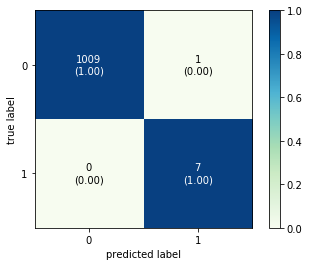

In [33]:
cm_svm = confusion_matrix(Ydev, Ypred)
fig, ax = plot_confusion_matrix(conf_mat=cm_svm, colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

## Random Forest Classifier

In [45]:
rf_clf = RandomForestClassifier(n_jobs=-1)

param_grid = {'n_estimators': np.arange(1, 101, 10), 'max_depth': np.arange(1,11)}

# Use grid search to find best hyperparameters
grid_cv = GridSearchCV(rf_clf, param_grid, scoring='f1', cv=5)

grid_cv.fit(Xtrain_res, Ytrain_res)

print('Best no. of estimators:', grid_cv.best_estimator_.get_params()['n_estimators'])
print('Best max depth:', grid_cv.best_estimator_.get_params()['max_depth'])
print ("Best accuracy: ", grid_cv.best_score_)

Best no. of estimators: 41
Best max depth: 6
Best accuracy:  0.9039589253598744


### Fit and evaluate new model using optimal hyperparameters

In [46]:
rf_best_model = RandomForestClassifier(n_estimators=61, max_depth=5)

# Fit and evaluate on dev data
rf_best_model.fit(Xdev, Ydev)
print("Accuracy: ", rf_best_model.score(Xdev, Ydev))

# Get prediction on dev data
Ypred = rf_best_model.predict(Xdev)

# Get dev set metrics
f1_w = f1_score(Ydev, Ypred, average='weighted')
f1_mac = f1_score(Ydev, Ypred, average='macro')
print('The weighted F1 score is:', f1_w*100)
print('The macro F1 score is:', f1_mac*100)

print(classification_report(Ydev, Ypred))

# Get AUC score
print('AUC score on dev set: ', roc_auc_score(Ydev, Ypred))

Accuracy:  1.0
The weighted F1 score is: 100.0
The macro F1 score is: 100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00      1017
   macro avg       1.00      1.00      1.00      1017
weighted avg       1.00      1.00      1.00      1017

AUC score on dev set:  1.0


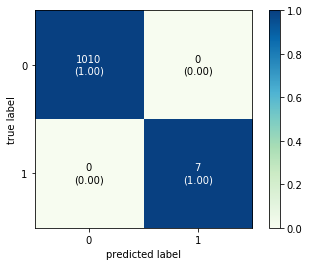

In [35]:
cm_rf = confusion_matrix(Ydev, Ypred)
fig, ax = plot_confusion_matrix(conf_mat=cm_rf, colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

## Decision Tree Classifier

In [47]:
dt_clf = DecisionTreeClassifier()

param_grid = {'max_depth': np.arange(1,11), 'min_samples_split': np.arange(2,6)}

# Use grid search to find best hyperparameters
grid_cv = GridSearchCV(dt_clf, param_grid, scoring='f1', cv=5)

grid_cv.fit(Xtrain_res, Ytrain_res)

print('Best max depth:', grid_cv.best_estimator_.get_params()['max_depth'])
print('Best min. samples split:', grid_cv.best_estimator_.get_params()['min_samples_split'])
print ("Best accuracy: ", grid_cv.best_score_)

Best max depth: 5
Best min. samples split: 2
Best accuracy:  0.9027034062739862


### Fit and evaluate new model using optimal hyperparameters

In [48]:
dt_best_model = DecisionTreeClassifier(max_depth=5, min_samples_split=2)

# Fit and evaluate on dev data
dt_best_model.fit(Xdev, Ydev)
print("Accuracy: ", dt_best_model.score(Xdev, Ydev))

# Get prediction on dev data
Ypred = dt_best_model.predict(Xdev)

# Get dev set metrics
f1_w = f1_score(Ydev, Ypred, average='weighted')
f1_mac = f1_score(Ydev, Ypred, average='macro')
print('The weighted F1 score is:', f1_w*100)
print('The macro F1 score is:', f1_mac*100)

print(classification_report(Ydev, Ypred))

# Get AUC score
print('AUC score on dev set: ', roc_auc_score(Ydev, Ypred))

Accuracy:  1.0
The weighted F1 score is: 100.0
The macro F1 score is: 100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00      1017
   macro avg       1.00      1.00      1.00      1017
weighted avg       1.00      1.00      1.00      1017

AUC score on dev set:  1.0


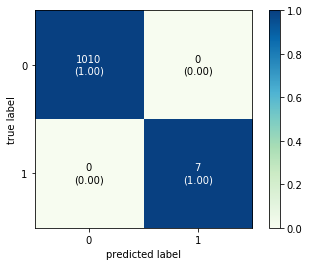

In [37]:
cm_dt = confusion_matrix(Ydev, Ypred)
fig, ax = plot_confusion_matrix(conf_mat=cm_dt, colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

## XGBoost Classifier

In [39]:
xg_clf = xgboost.XGBClassifier(objective='binary:logistic',
                               learning_rate=0.1,
                               n_estimators=1000,
                               max_depth=1,
                               min_child_weight=3,
                               gamma=0,
                               subsample=0.8,
                               colsample_bytree=0.75,
                               scale_pos_weight = 1,
                               reg_alpha = 0,
                               n_jobs=-1)

param_grid = {'learning_rate':[0.001, 0.01, 0.1]}

grid_cv = GridSearchCV(xg_clf, param_grid, scoring='f1', cv=5)

grid_cv.fit(Xtrain_res, Ytrain_res)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'learning_rate': 0.1}
0.9036965468012474


In [40]:
xg_best_model = xgboost.XGBClassifier(objective='binary:logistic',
                               learning_rate=0.1,
                               n_estimators=1000,
                               max_depth=1,
                               min_child_weight=3,
                               gamma=0,
                               subsample=0.8,
                               colsample_bytree=0.75,
                               scale_pos_weight = 1,
                               reg_alpha = 0,
                               n_jobs=-1)

xg_best_model.fit(Xtrain_res, Ytrain_res,
        early_stopping_rounds=5,
        eval_set = [(Xtrain, Ytrain), (Xdev, Ydev)],
        eval_metric = 'error')

[0]	validation_0-error:0.051622	validation_1-error:0.042281
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.051622	validation_1-error:0.042281
[2]	validation_0-error:0.051622	validation_1-error:0.042281
[3]	validation_0-error:0.051622	validation_1-error:0.042281
[4]	validation_0-error:0.051622	validation_1-error:0.042281
[5]	validation_0-error:0.051622	validation_1-error:0.042281
Stopping. Best iteration:
[0]	validation_0-error:0.051622	validation_1-error:0.042281



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.75, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=1,
       min_child_weight=3, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

### Fit and evaluate new model using optimal hyperparameters

In [43]:
# Get prediction on dev data
Ypred = xg_best_model.predict(Xdev)
print("Accuracy: ", dt_best_model.score(Xdev, Ydev))

# Get dev set metrics
f1_w = f1_score(Ydev, Ypred, average='weighted')
f1_mac = f1_score(Ydev, Ypred, average='macro')
print('The weighted F1 score is:', f1_w*100)
print('The macro F1 score is:', f1_mac*100)

print(classification_report(Ydev, Ypred))

# Get AUC score
print('AUC score on dev set: ', roc_auc_score(Ydev, Ypred))

Accuracy:  1.0
The weighted F1 score is: 97.3207148993951
The macro F1 score is: 61.19319543167479
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1010
           1       0.14      1.00      0.25         7

   micro avg       0.96      0.96      0.96      1017
   macro avg       0.57      0.98      0.61      1017
weighted avg       0.99      0.96      0.97      1017

AUC score on dev set:  0.9787128712871287


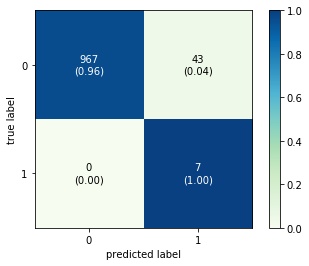

In [44]:
cm_xg = confusion_matrix(Ydev, Ypred)
fig, ax = plot_confusion_matrix(conf_mat=cm_xg, colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

## Voting Classifier

In [49]:
log_clf = LogisticRegression(C=1, penalty="l2")
rnd_clf = RandomForestClassifier(n_estimators=61, max_depth=5)
dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2)
svm_clf = SVC(C= 1000, kernel='rbf')
xg_clf = xgboost.XGBClassifier(objective='binary:logistic',
                               learning_rate=0.1,
                               n_estimators=1000,
                               max_depth=1,
                               min_child_weight=3,
                               gamma=0,
                               subsample=0.8,
                               colsample_bytree=0.75,
                               scale_pos_weight = 1,
                               reg_alpha = 0,
                               n_jobs=-1)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('dt', dt_clf), ('svc', svm_clf), ('xg', xg_clf)],
    voting='hard')
voting_clf.fit(Xtrain_res, Ytrain_res)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...ha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

### Fit and evaluate new model using optimal hyperparameters

In [57]:
cm = []
for clf in (log_clf, rnd_clf, dt_clf, svm_clf, xg_clf, voting_clf):
    clf.fit(Xtrain_res, Ytrain_res)
    print("Accuracy: ", clf.score(Xdev, Ydev))
    Ypred = clf.predict(Xdev)
    cm.append(confusion_matrix(Ydev, Ypred))
    print(clf.__class__.__name__, f1_score(Ydev, Ypred, average='macro'), f1_score(Ydev, Ypred, average='weighted'),
          precision_score(Ydev, Ypred), recall_score(Ydev, Ypred), roc_auc_score(Ydev, Ypred))

Accuracy:  0.9085545722713865
LogisticRegression 0.5412897875250378 0.9460882260971123 0.07 1.0 0.953960396039604
Accuracy:  0.9478859390363815
RandomForestClassifier 0.591005319108575 0.9677961209902485 0.11666666666666667 1.0 0.9737623762376237
Accuracy:  0.9459193706981318
DecisionTreeClassifier 0.587454364420843 0.9667163911045147 0.11290322580645161 1.0 0.9727722772277227
Accuracy:  0.9410029498525073
SVC 0.579288472145615 0.9640176568115886 0.1044776119402985 1.0 0.9702970297029703
Accuracy:  0.9478859390363815
XGBClassifier 0.591005319108575 0.9677961209902485 0.11666666666666667 1.0 0.9737623762376237
Accuracy:  0.943952802359882
VotingClassifier 0.584072955306982 0.9656368946241688 0.109375 1.0 0.9717821782178218


## Generate Plots of Confusion Matrices

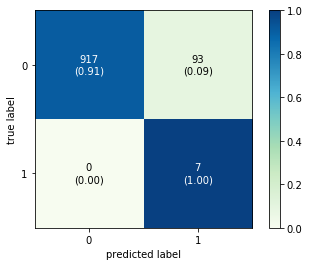

In [61]:
# Logistic Regression
fig, ax = plot_confusion_matrix(conf_mat=cm[0], colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

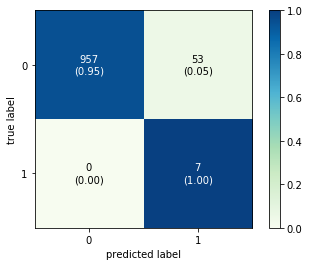

In [62]:
# Random Forest
fig, ax = plot_confusion_matrix(conf_mat=cm[1], colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

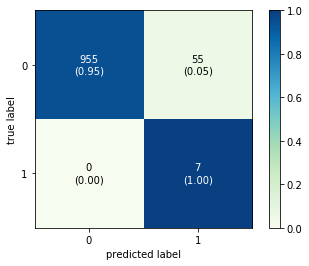

In [63]:
# Decision Tree
fig, ax = plot_confusion_matrix(conf_mat=cm[2], colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

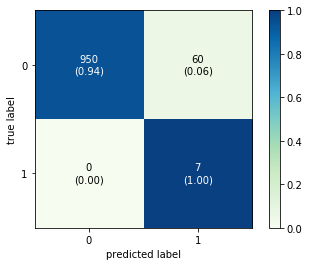

In [64]:
# SVM
fig, ax = plot_confusion_matrix(conf_mat=cm[3], colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

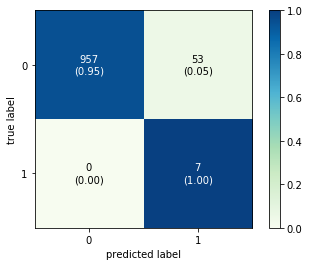

In [65]:
# XGBoost
fig, ax = plot_confusion_matrix(conf_mat=cm[4], colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

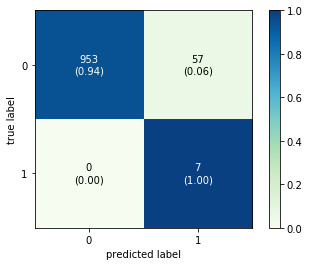

In [66]:
# Voting
fig, ax = plot_confusion_matrix(conf_mat=cm[5], colorbar=True, show_absolute=True, show_normed=True, cmap = 'GnBu')
plt.show()

## Use best model to make predictions on test data

In [39]:
Xtest = Xtest.flatten().reshape(-1, 1)
predictions = voting_clf.predict(Xtest)

# Reshape predictions into 300 x 15 matrix
predictions = predictions.reshape(300,15)

# Save predictions to csv file
pd.DataFrame(predictions).to_csv('test_solution.csv', header=False, index=False)